#### Origem dos Dados: https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

In [ ]:
import pandas as pd
from sklearn.metrics import mutual_info_score,roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
!unzip Dataset.zip

Archive:  Dataset.zip
  inflating: heart.csv               
  inflating: o2Saturation.csv        


In [ ]:
Heart = pd.read_csv('heart.csv')


In [20]:
Heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
correlation_matrix = Heart.corr()
correlation_with_output = correlation_matrix['output'].sort_values(ascending=False)

print(correlation_with_output)


output      1.000000
cp          0.433798
thalachh    0.421741
slp         0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trtbps     -0.144931
age        -0.225439
sex        -0.280937
thall      -0.344029
caa        -0.391724
oldpeak    -0.430696
exng       -0.436757
Name: output, dtype: float64


In [ ]:
mutual_info_scores = {}
for column in Heart.columns:
  if column != 'output':
    mutual_info_scores[column] = mutual_info_score(Heart['output'], Heart[column])

print("Mutual Information Scores:")
for column, score in mutual_info_scores.items():
  print(f"{column}: {score}")


Mutual Information Scores:
age: 0.09378647273031647
sex: 0.04099155186447881
cp: 0.14181711991875448
trtbps: 0.09733730013642071
chol: 0.3879797954670116
fbs: 0.0003922398104876379
restecg: 0.0166874048825605
thalachh: 0.2322723359455063
exng: 0.09857280295977083
oldpeak: 0.17563546295064109
slp: 0.08098301623981687
caa: 0.12889578371853533
thall: 0.14781412287066148


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


#### Note que sexo e idade tem um baixo score de informação mutua em relação à output, indicando que os ataques cardíacos podem não ter uma relação direta com idade e sexo.

In [ ]:
combined_scores = {}
for column in Heart.columns:
  if column != 'output':
    correlation = correlation_matrix['output'][column]
    mutual_info = mutual_info_scores.get(column, 0)
    combined_scores[column] = (abs(correlation) + mutual_info)


sorted_combined_scores = dict(sorted(combined_scores.items(), key=lambda item: item[1], reverse=True))

top_5_variables = list(sorted_combined_scores.keys())[:5]

print("Top 5 mais relacionadas com ataques cardiacos")
print(top_5_variables)


Top 5 mais relacionadas com ataques cardiacos
['thalachh', 'oldpeak', 'cp', 'exng', 'caa']


#### Correlação de Pearson :

1: Correlação linear positiva perfeita. </br>
-1: Correlação linear negativa perfeita. </br>
0: Nenhuma correlação linear.

In [34]:
from itertools import combinations
from scipy.stats import pearsonr

highest_correlation = 0
best_pair = None
corr_dict = {}

# Iterando sobre todas as combinações de 2 variáveis em top_5_variables
for pair in combinations(top_5_variables, 2):
    var1, var2 = pair

    # Calculando a correlação de Pearson entre var1 e var2
    correlation, _ = pearsonr(Heart[var1], Heart[var2])

    corr_dict[f"{var1} x {var2}"] = correlation

    if abs(correlation) > abs(highest_correlation):
        highest_correlation = correlation
        best_pair = pair

sorted_corr_dict = sorted(corr_dict.items(), key=lambda item: abs(item[1]), reverse=True)

print("Pares de variáveis e suas correlações em ordem de magnitude:")
for pair, score in sorted_corr_dict:
    print(f"{pair}: {score}")

print(f"\nO par de variáveis com maior correlação de Pearson é: {best_pair} com uma correlação de {highest_correlation}")


Pares de variáveis e suas correlações em ordem de magnitude:
cp x exng: -0.3942802684950219
thalachh x exng: -0.37881209385148684
thalachh x oldpeak: -0.3441869479667158
thalachh x cp: 0.2957621245879106
oldpeak x exng: 0.2882228077827654
oldpeak x caa: 0.2226823218278237
thalachh x caa: -0.21317692811538988
cp x caa: -0.18105302605349524
oldpeak x cp: -0.14923015809708082
exng x caa: 0.11573937807050619

O par de variáveis com maior correlação de Pearson é: ('cp', 'exng') com uma correlação de -0.3942802684950219


#### Vamos escolher as 5 com maior magnitude, isso pode ajudar ainda mais o modelo a aprender com combinações relevantes. Por exemplo, agora sabemos que o tipo de dor de peito e angina atrelada à exercícios estão negativamente correlacionadas.

*   thalachh: Frequência cardíaca máxima alcançada
*   oldpeak:  Indicador importante na avaliação da presença de isquemia miocárdica, que é a redução do fluxo sanguíneo para o coração.
*   cp: Tipo de dor no peito
*   exng: Angina induzida por exercício
*   caa: Número de artérias coronárias maiores afetadas por doenças






In [35]:
X = Heart[top_5_variables]
y = Heart['output']

Heart['cp_x_exng'] = Heart['cp'] * Heart['exng']
Heart['thalachh_x_exng'] = Heart['thalachh'] * Heart['exng']
Heart['thalachh_x_oldpeak'] = Heart['thalachh'] * Heart['oldpeak']
Heart['thalachh_x_cp'] = Heart['thalachh'] * Heart['cp']
Heart['oldpeak_x_exng'] = Heart['oldpeak'] * Heart['exng']

X = pd.concat([X, Heart[['cp_x_exng', 'thalachh_x_exng', 'thalachh_x_oldpeak',
                          'thalachh_x_cp', 'oldpeak_x_exng']]], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler() #Normalização é importante, dados muito dispersos!
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Probabilidades de Ataque Cardíaco para os dados de teste:")
print(y_pred_proba)



Probabilidades de Ataque Cardíaco para os dados de teste:
[1.08483525e-01 9.48257393e-01 8.62529210e-01 8.63929124e-03
 7.71025066e-01 8.29504833e-01 4.81993568e-01 2.67526389e-04
 9.22831673e-04 7.77811512e-01 7.30582810e-01 4.52543074e-01
 8.79724608e-01 2.79113083e-02 8.94520345e-01 9.46739540e-01
 8.68513234e-01 3.13111736e-01 8.69484110e-03 1.07684287e-03
 9.26743615e-01 4.85453245e-02 4.61819782e-01 5.41950232e-01
 7.92926827e-01 8.37416537e-01 9.10829060e-01 5.48643162e-01
 1.23977128e-01 8.02094441e-01 1.78793171e-01 1.73541416e-02
 7.79305223e-03 6.55798362e-03 5.94549720e-01 3.81307080e-01
 7.05250670e-01 7.77790730e-01 9.29071793e-01 8.43263150e-01
 4.03699362e-01 8.28011661e-01 8.42469487e-01 7.67617040e-01
 8.95872072e-01 3.30299126e-02 1.55620444e-01 9.09756367e-01
 1.95442085e-03 9.95261054e-02 1.64768634e-01 8.20780523e-02
 8.26562101e-01 8.52170174e-01 4.98697310e-01 4.49444067e-03
 1.91729905e-01 9.29115461e-01 6.32856281e-02 1.92490679e-03
 3.32660682e-01]


In [36]:
y_train_0_percentage = (y_train == 0).sum() / len(y_train) * 100
y_train_1_percentage = (y_train == 1).sum() / len(y_train) * 100

print(f"Porcentagem de 0 (sem ataque cardíaco) no treino: {y_train_0_percentage:.2f}%")
print(f"Porcentagem de 1 (ataque cardíaco) no treino: {y_train_1_percentage:.2f}%")

Porcentagem de 0 (sem ataque cardíaco) no treino: 45.04%
Porcentagem de 1 (ataque cardíaco) no treino: 54.96%


In [37]:
y_test_0_percentage = (y_test == 0).sum() / len(y_test) * 100
y_test_1_percentage = (y_test == 1).sum() / len(y_test) * 100

print(f"Porcentagem de 0 (sem ataque cardíaco) no teste: {y_test_0_percentage:.2f}%")
print(f"Porcentagem de 1 (ataque cardíaco) no teste: {y_test_1_percentage:.2f}%")

Porcentagem de 0 (sem ataque cardíaco) no teste: 47.54%
Porcentagem de 1 (ataque cardíaco) no teste: 52.46%


#### Está praticamente balanceado em treino e teste

In [38]:

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Encontrar o melhor threshold usando Youden's J statistic

#J=Sensibilidade+Especificidade−1

j_statistic = tpr - fpr
best_threshold_index = j_statistic.argmax()
best_threshold = thresholds[best_threshold_index]

print(f"Melhor Threshold: {best_threshold}")



Melhor Threshold: 0.4036993622827729


In [39]:
print("Ataque Cardíaco para os dados de teste:")
print(y_pred_proba > best_threshold)


Ataque Cardíaco para os dados de teste:
[False  True  True False  True  True  True False False  True  True  True
  True False  True  True  True False False False  True False  True  True
  True  True  True  True False  True False False False False  True False
  True  True  True  True False  True  True  True  True False False  True
 False False False False  True  True  True False False  True False False
 False]


In [40]:
from sklearn.metrics import confusion_matrix

y_pred = (y_pred_proba > best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)

print("Matriz de Confusão:")
print(cm)


Matriz de Confusão:
[[24  5]
 [ 3 29]]


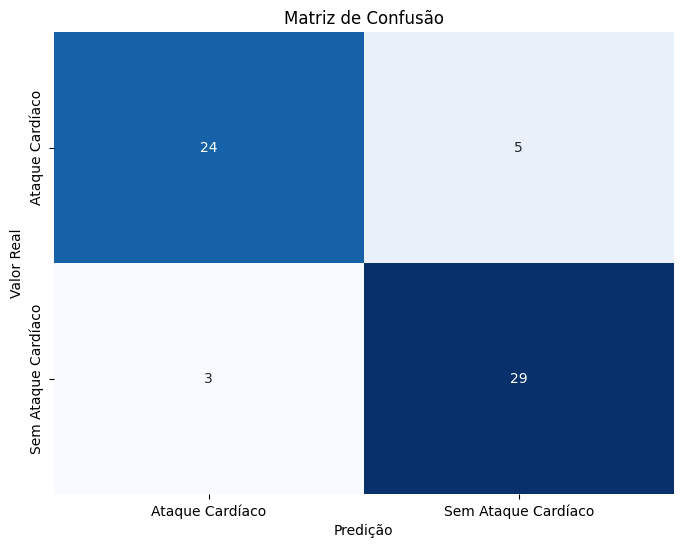

In [54]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Ataque Cardíaco', 'Sem Ataque Cardíaco'],
            yticklabels=['Ataque Cardíaco', 'Sem Ataque Cardíaco'])
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
plt.show()


In [42]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Acurácia: 0.87
Precisão: 0.85
Recall: 0.91
F1-Score: 0.88


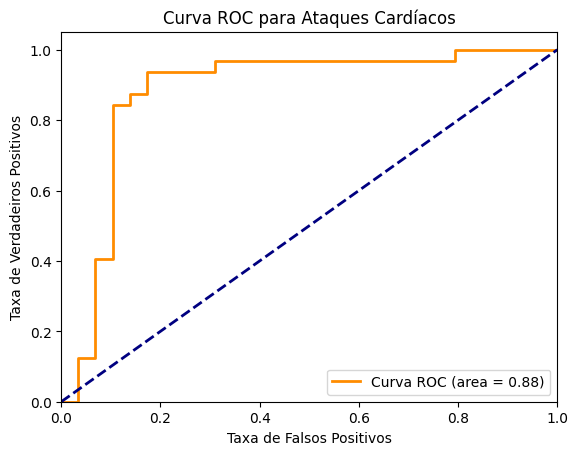

In [43]:
ROC_Final = roc_curve(y_test, y_pred_proba)
fpr,tpr,_ = ROC_Final
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para Ataques Cardíacos')
plt.legend(loc="lower right")
plt.show()


#### Fizemos uma boa escolha com o número de variáveis (5)? Vamos tentar achar o melhor valor para treinar o modelo com base no fscore (com base em qual tem mais relação com output).
#### Lembrando que o fscore é uma excelente métrica para se basear dado que é uma média harmônica entre acurácia e recall, duas métricas que avaliam o modelo em geral.

In [59]:
best_f1_score = 0
best_num_variables = 0
best_model = None
best_threshold_all = 0
print("-------------------------------------------------")

for num_variables in range(1, len(sorted_combined_scores) + 1):
    top_variables = list(sorted_combined_scores.keys())[:num_variables]
    X = Heart[top_variables]
    y = Heart['output']
    Heart['cp_x_exng'] = Heart['cp'] * Heart['exng']
    Heart['thalachh_x_exng'] = Heart['thalachh'] * Heart['exng']
    Heart['thalachh_x_oldpeak'] = Heart['thalachh'] * Heart['oldpeak']
    Heart['thalachh_x_cp'] = Heart['thalachh'] * Heart['cp']
    Heart['oldpeak_x_exng'] = Heart['oldpeak'] * Heart['exng']

    X = pd.concat([X, Heart[['cp_x_exng', 'thalachh_x_exng', 'thalachh_x_oldpeak',
                              'thalachh_x_cp', 'oldpeak_x_exng']]], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    j_statistic = tpr - fpr
    best_threshold_index = j_statistic.argmax()
    best_threshold = thresholds[best_threshold_index]
    y_pred = (y_pred_proba > best_threshold).astype(int)

    current_f1_score = f1_score(y_test, y_pred)

    if current_f1_score > best_f1_score:
        best_threshold_all = best_threshold
        best_model = model
        best_f1_score = current_f1_score
        best_num_variables = num_variables
    print(f"F1-score para {' ' * (2 - len(str(num_variables)))}{num_variables} variáveis: {current_f1_score:.4f}")

print("-------------------------------------------------")

print(f"Melhor número de variáveis: {best_num_variables}")
print(f"Melhor F1-score: %.4f"%best_f1_score)
print(f"Melhor threshold: %.4f"%best_threshold_all)
print(f"Variáveis: {list(sorted_combined_scores.keys())[:best_num_variables]}")


-------------------------------------------------
F1-score para  1 variáveis: 0.8438
F1-score para  2 variáveis: 0.8197
F1-score para  3 variáveis: 0.8197
F1-score para  4 variáveis: 0.8197
F1-score para  5 variáveis: 0.8788
F1-score para  6 variáveis: 0.8571
F1-score para  7 variáveis: 0.8571
F1-score para  8 variáveis: 0.8571
F1-score para  9 variáveis: 0.8889
F1-score para 10 variáveis: 0.8889
F1-score para 11 variáveis: 0.8710
F1-score para 12 variáveis: 0.8750
F1-score para 13 variáveis: 0.8750
-------------------------------------------------
Melhor número de variáveis: 9
Melhor F1-score: 0.8889
Melhor threshold: 0.4097
Variáveis: ['thalachh', 'oldpeak', 'cp', 'exng', 'caa', 'thall', 'chol', 'slp', 'sex']


#### Com  9 variáveis o resultado é ligeiramente melhor. Sendo elas:

- thalachh
- oldpeak
- cp
- exng
- caa
- thall
- chol
- slp
- sex


#### Vamos treinar outro modelo com essas 9 variáveis (além das 5 combinações anteriores)

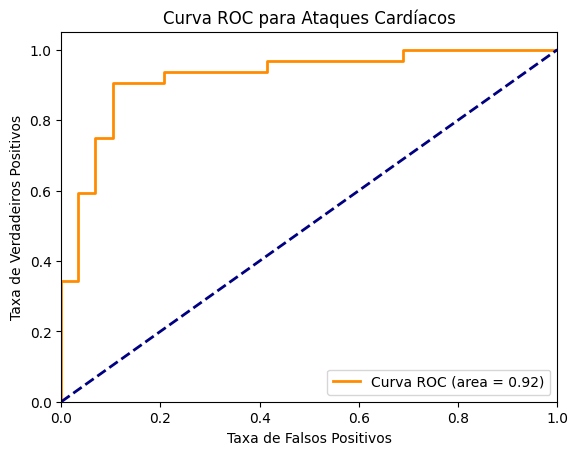

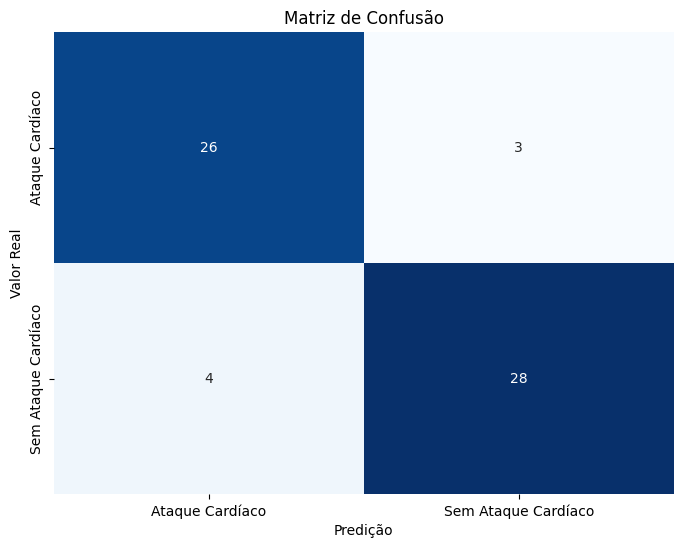


Acurácia: 0.89
Precisão: 0.90
Recall: 0.88
F1-Score: 0.89


In [64]:
top_variables = ['thalachh', 'oldpeak', 'cp', 'exng', 'caa', 'thall', 'chol', 'slp', 'sex']
X = Heart[top_variables]
y = Heart['output']

Heart['cp_x_exng'] = Heart['cp'] * Heart['exng']
Heart['thalachh_x_exng'] = Heart['thalachh'] * Heart['exng']
Heart['thalachh_x_oldpeak'] = Heart['thalachh'] * Heart['oldpeak']
Heart['thalachh_x_cp'] = Heart['thalachh'] * Heart['cp']
Heart['oldpeak_x_exng'] = Heart['oldpeak'] * Heart['exng']

X = pd.concat([X, Heart[['cp_x_exng', 'thalachh_x_exng', 'thalachh_x_oldpeak',
                          'thalachh_x_cp', 'oldpeak_x_exng']]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

y_pred = (y_pred_proba > best_threshold_all).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


ROC_Final = roc_curve(y_test, y_pred_proba)
fpr,tpr,_ = ROC_Final
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para Ataques Cardíacos')
plt.legend(loc="lower right")
plt.show()
print()
print()
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Ataque Cardíaco', 'Sem Ataque Cardíaco'],
            yticklabels=['Ataque Cardíaco', 'Sem Ataque Cardíaco'])
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
plt.show()

print()
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")




In [65]:
import pickle

filename = 'best_model.sav'
pickle.dump(best_model, open(filename, 'wb'))
